In [1]:
import os
import random
import numpy as np
import torch
import glob
import time
import matplotlib.pyplot as plt
from torch.autograd import Variable
from utils.architectures.autoreg import SimpleClass
from utils.architectures.inceptionv4 import InceptionV4
from sklearn.metrics import mean_squared_error as mse
from skimage.measure import compare_ssim as ssim
import scipy.signal
import natsort
import math
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    print(ret.shape)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def rescale(arr, scale=255):
    arr = arr.astype(np.float64)
    arr[arr<0] = 0
#     arr = arr - arr.min()
    arr = arr/arr.max()*scale
    return arr

def T1fromMRF(MRF, regressor, model, signal_length=999999, is_regressor=False, gpu="3"):
    device = torch.device("cuda:" + gpu)
    
    regressor.to(device)
    regressor.load_state_dict(torch.load(model))
    a = regressor.eval()

    MRF = MRF.reshape(1000,-1).T
    MRF = Variable(torch.from_numpy(MRF).type(torch.FloatTensor))
    MRF = MRF.to(device).view(-1,2,500)

    T1_array = np.array([])
    # break calculation into blocks so not to kill the GPU
    blocks = 128
    blocks = 4096
    slice_len = int(np.ceil(MRF.size()[0]/blocks))
    max_len = len(MRF)
    for i in range(blocks):
        if i*slice_len >= max_len:
            break
        if i % (blocks//10) == 0:
            print(i)
            pass
        chunk = MRF[i*slice_len:(i+1)*slice_len]
        chunk = chunk[:,:,0:signal_length]
        T1 = regressor(chunk)
        if not is_regressor:
            T1 = T1.data.max(1)[1]
        T1 = T1.data.cpu().numpy()
        T1_array = np.concatenate((T1_array, T1.flatten()))

    print("mean: ", np.mean(T1_array))
    return T1_array.reshape(320,320)

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    print(ret.shape)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

# Learning Curves

In [24]:
x = np.load("outputs/lossclass200epoch80t2.npy")

(7216,)


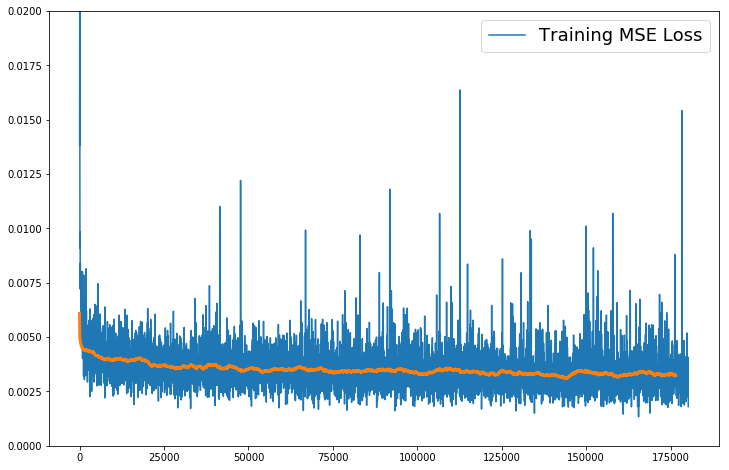

In [25]:
plt.figure(figsize=(12,8))
plt.plot(x[:,1], x[:,3], label="Training MSE Loss")

ma = moving_average(x[:,3],150)

plt.plot(x[:len(ma),1], ma, linewidth=3)
plt.ylim(0,0.02)
plt.legend(prop={'size': 18})
plt.show()

(7216,)


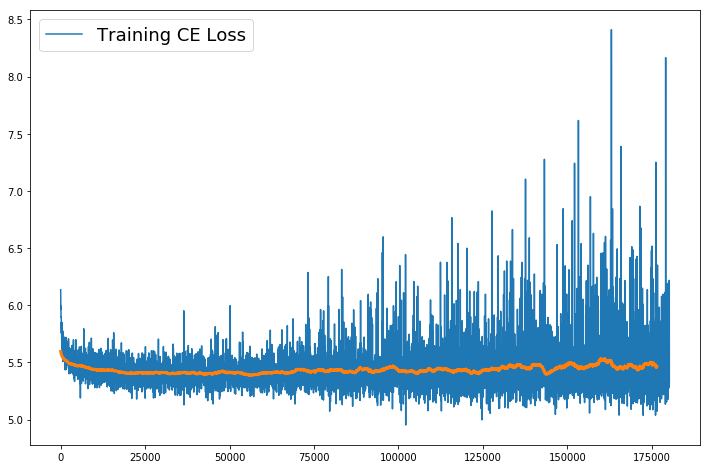

In [27]:
plt.figure(figsize=(12,8))
plt.plot(x[:,1], x[:,2], label="Training CE Loss")

ma = moving_average(x[:,2],150)

plt.plot(x[:len(ma),1], ma, linewidth=3)
# plt.ylim(0,0.02)
plt.legend(prop={'size': 18})
plt.show()

In [24]:
x = np.load("outputs/train_lossreg200epoch.npy")
y = np.load("outputs/val_lossreg200epoch.npy")

(14626,)


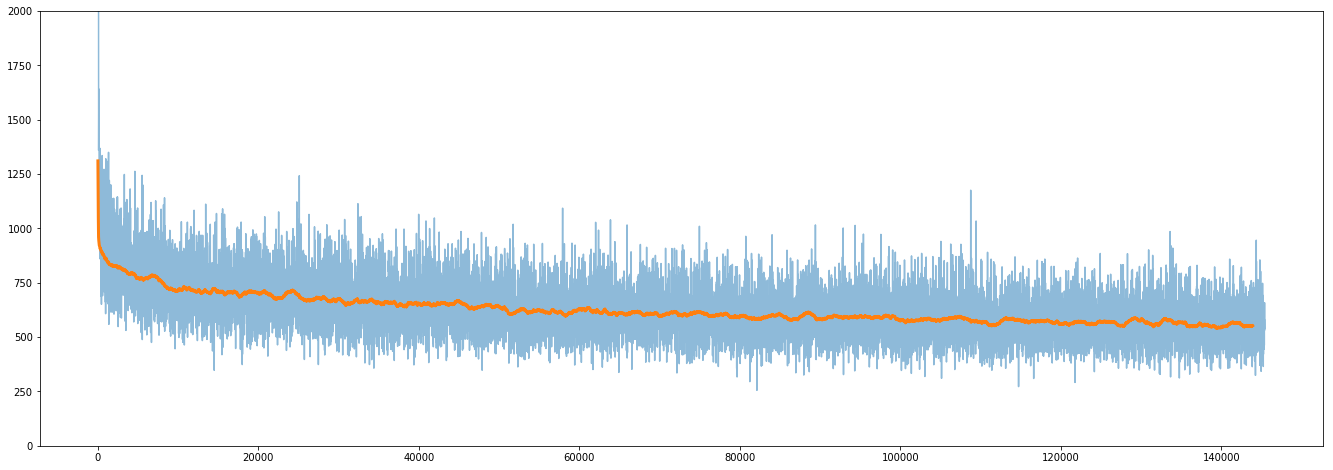

In [73]:
plt.figure(figsize=(23,8))
plt.plot(x[:,1], x[:,2], alpha=0.5)

ma = moving_average(x[:,2],150)

plt.plot(x[:len(ma),1], ma, linewidth=3)
plt.ylim(0,2000)
plt.show()

(710,)


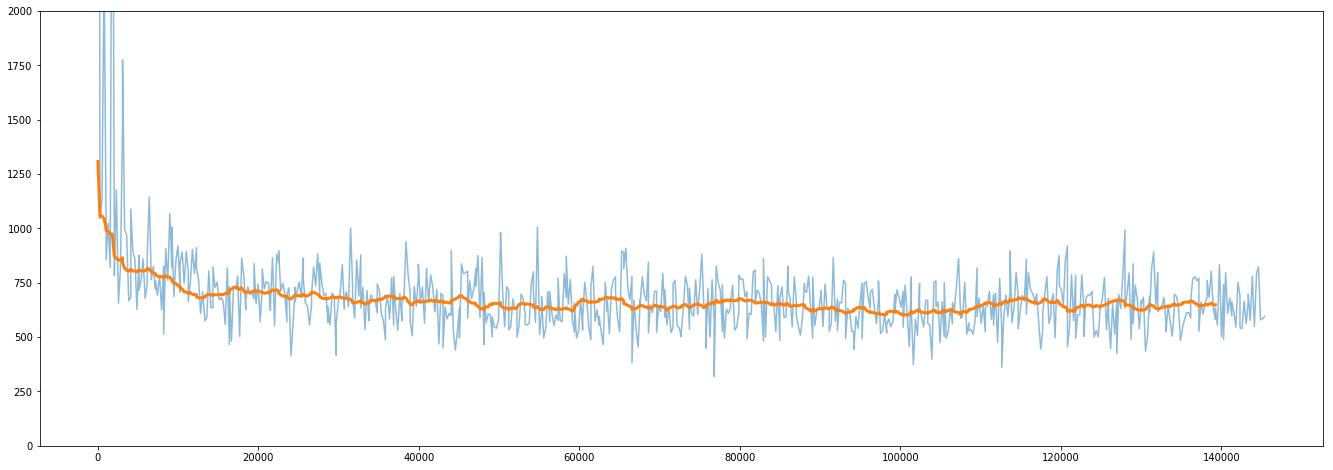

In [71]:
plt.figure(figsize=(23,8))
plt.plot(y[:,1], y[:,2], alpha=0.5)

ma = moving_average(y[:,2],30)

plt.plot(y[:len(ma),1], ma, linewidth=3)
plt.ylim(0,2000)
plt.show()

# Alpha Annealing

In [4]:
# models = natsort.natsorted(glob.glob("models/old_models/normalized*"))

In [5]:
# regressor = InceptionV4(num_classes=256)
# for model in models:
#     for j in range(1,11):
#         MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(j) + ".npy")
#         T1_recon = T1fromMRF(MRF, regressor, model)
#         np.save("outputs/" + model.split("/")[-1] + "trial" + str(j), T1_recon)

In [2]:
testnames = natsort.natsorted(glob.glob("data/T1w_test/*"))

In [3]:
filenames = np.array(natsort.natsorted(glob.glob("outputs/normalized*.npy")))
filenames = filenames.reshape(-1,10)

In [4]:
ssims = []
psnrs = []
for category in filenames:
    for filename, testname in zip(category, testnames):
        recon = np.load(filename)
        test = np.load(testname)[0]
        ssims.append(ssim(rescale(recon),rescale(test)))
        psnrs.append(psnr(rescale(recon),rescale(test)))
ssims = np.array(ssims)
psnrs = np.array(psnrs)

In [5]:
alphas = np.round(np.linspace(0,1,6),1)
alphas_repeat = np.repeat(alphas, 10)
ssims_array = np.array(ssims).reshape(-1,10)
psnrs_array = np.array(psnrs).reshape(-1,10)

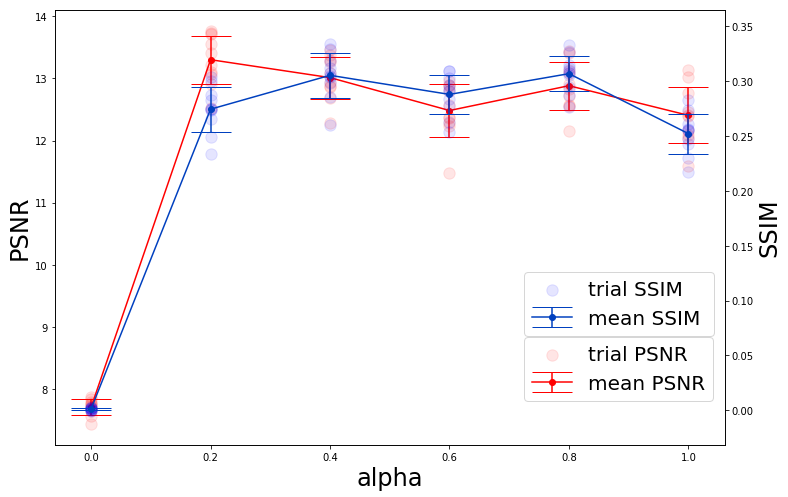

In [6]:
fig1, ax1 = plt.subplots()
fig1.set_figheight(8)
fig1.set_figwidth(12)
ax1.scatter(alphas_repeat, psnrs, s=130, alpha=0.1,c="red", label="trial PSNR")
ax1.set_ylabel("PSNR", fontsize=24)
ax1.errorbar(alphas, np.mean(psnrs_array, axis=1), np.std(psnrs_array, axis=1), marker='o', c=(1,0,0), capsize=20, label="mean PSNR")
ax1.set_xlabel("alpha", fontsize=24)

ax2 = ax1.twinx()

ax2.scatter(alphas_repeat, ssims, s=130, alpha=0.1,c="blue", label="trial SSIM")
ax2.set_ylabel("SSIM", fontsize=24)
ax2.errorbar(alphas, np.mean(ssims_array, axis=1), np.std(ssims_array, axis=1), marker='o', c=(0,0.25,0.75), capsize=20, label="mean SSIM ")

ax1.legend(loc=(0.70,0.1), prop={'size': 20})
ax2.legend(loc=(0.70,0.25), prop={'size': 20})

# ax1.set_xlabel("Number of Points",  fontsize=23)
# ax1.set_ylabel("Overall Accuracy", fontsize=23)
# ax1.tick_params(labelsize=20)

# ax1.set_xscale('log')
# ax1.set_xticks([20, 40, 80,160,320,640,1280,2560,5120])
# ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

# Image Generation

# Confusion Matrix


In [2]:
i = 1

In [3]:
regressor = InceptionV4(num_classes=1024)
model = "models/class1024alpha20epoch50T1"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
T1_test = np.load("data/T1w_test/T1_norm_volunteer12_" + str(i) + ".npy")[0]

In [4]:
T1_recon = T1fromMRF(MRF, regressor, model, gpu="2", is_regressor=False)

0
12
24
36
48
60
72
84
96
108
120
mean:  205.80203125


In [5]:
mask = np.load("data/MRF_test_masks/MRF_norm_volunteer12_" + str(i) + ".npy")

# rescale to 0-255
T1_recon = rescale(T1_recon)
T1_test = rescale(T1_test)
MRF_T1 = rescale(np.load("outputs/MRF_dictionary_recon/MRF_norm_volunteer12_" + str(i) + ".npy"))

# mask
T1_recon[mask == 0] = 0

In [21]:
x = np.uint8(T1_recon).flatten()
y = np.uint8(T1_test).flatten()

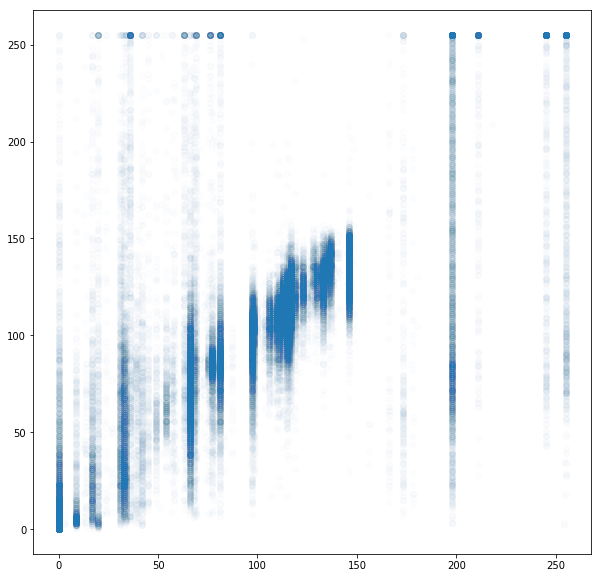

In [45]:
plt.figure(figsize=(10,10))
plt.scatter(x,y, alpha=0.01)
plt.show()

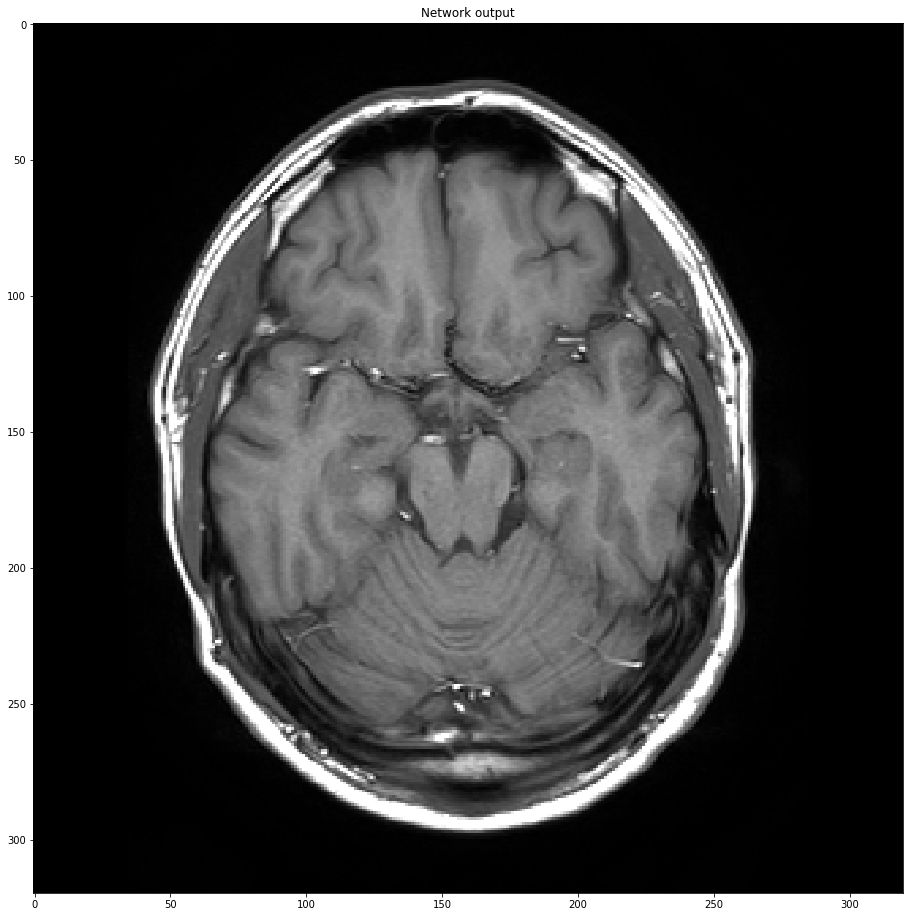

In [11]:
plt.figure(figsize=(16,16))
plt.title("Network output")
plt.imshow(x, cmap="gray",vmin=0,vmax=255)
plt.savefig(str(i) + model.split("/")[-1] + ".png")

# SSIMs PSNRs

In [2]:
T1_recons = np.reshape(natsort.natsorted(glob.glob("outputs/05-05/*/*T1.npy")), (-1,10))
T2_recons = np.reshape(natsort.natsorted(glob.glob("outputs/05-05/*/*T2.npy")), (-1,10))
T1_MRFs = natsort.natsorted(glob.glob("outputs/MRF_dictionary_recon/*T1.npy"))
T2_MRFs = natsort.natsorted(glob.glob("outputs/MRF_dictionary_recon/*T2.npy"))
T1Ws = natsort.natsorted(glob.glob("data/T1w_test/*"))
T2Ws = natsort.natsorted(glob.glob("data/T2w_test/*"))

print(T1_recons[:,0])
# ORDER IS:
# DIMENSION 1: MODEL TYPE
# DIMENSION 2: recon-true, mrf-true, recon-mrf

T1_SSIM = np.zeros((len(T1_recons), 3, len(T1Ws)))
T2_SSIM = np.zeros((len(T1_recons), 3, len(T1Ws)))
T1_PSNR = np.zeros((len(T1_recons), 3, len(T1Ws)))
T2_PSNR = np.zeros((len(T1_recons), 3, len(T1Ws)))

['outputs/05-05/alpha20T1/1class1024alpha20epoch50T1.npy'
 'outputs/05-05/alpha80T1/1class1024alpha80epoch50T1.npy'
 'outputs/05-05/alpha100T1/1class1024alpha100epoch50T1.npy'
 'outputs/05-05/regT1/1regepoch100T1.npy']


In [3]:
for i in range(len(T1_recons)):
    for j in range(len(T1_MRFs)):
        T1_recon = rescale(np.load(T1_recons[i,j]))
        T1_MRF = rescale(np.load(T1_MRFs[j]))
        T1W = rescale(np.load(T1Ws[j])[0])
        
        T1_SSIM[i,0,j] = ssim(T1_recon, T1W)
        T1_SSIM[i,1,j] = ssim(T1_MRF, T1W)
        T1_SSIM[i,2,j] = ssim(T1_recon, T1_MRF)
        
        T1_PSNR[i,0,j] = psnr(T1_recon, T1W)
        T1_PSNR[i,1,j] = psnr(T1_MRF, T1W)
        T1_PSNR[i,2,j] = psnr(T1_recon, T1_MRF)

In [4]:
for i in range(len(T2_recons)):
    for j in range(len(T2_MRFs)):
        T2_recon = rescale(np.load(T2_recons[i,j]))
        T2_MRF = rescale(np.load(T2_MRFs[j]))
        T2W = rescale(np.load(T2Ws[j])[0])
        
        T2_SSIM[i,0,j] = ssim(T2_recon, T2W)
        T2_SSIM[i,1,j] = ssim(T2_MRF, T2W)
        T2_SSIM[i,2,j] = ssim(T2_recon, T2_MRF)
        
        T2_PSNR[i,0,j] = psnr(T2_recon, T2W)
        T2_PSNR[i,1,j] = psnr(T2_MRF, T2W)
        T2_PSNR[i,2,j] = psnr(T2_recon, T2_MRF)

In [ ]:
np.round(np.mean(T1_SSIM, axis=2).T,3)

In [ ]:
np.round(np.mean(T1_PSNR, axis=2).T,2)

In [ ]:
np.round(np.mean(T2_SSIM, axis=2).T,3)

In [ ]:
np.round(np.mean(T2_PSNR, axis=2).T,2)

# Recon Generation

In [ ]:
for i in range(1,11):
    regressor = InceptionV4(num_classes=256)
    model = "models/class1024alpha100epoch50T1"
    MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
    T1_recon = rescale(T1fromMRF(MRF, regressor, model, gpu="0", is_regressor=False))
    np.save("outputs/05-05/alpha100T1/" + str(i) + model.split("/")[-1], T1_recon)
    plt.figure(figsize=(16,16))
    plt.title("Network output")
    plt.imshow(T1_recon, cmap="gray",vmin=0,vmax=255)
    plt.savefig(str(i) + model.split("/")[-1] + ".png")

In [ ]:
for i in range(1,11):
    regressor = InceptionV4(num_classes=256)
    model = "models/class1024alpha100epoch50T2"
    MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")
    T2_recon = rescale(T1fromMRF(MRF, regressor, model, gpu="0", is_regressor=False))
    np.save("outputs/05-05/alpha100T2/" + str(i) + model.split("/")[-1], T2_recon)
    plt.figure(figsize=(16,16))
    plt.title("Network output")
    plt.imshow(T2_recon, cmap="gray",vmin=0,vmax=255)
    plt.savefig(str(i) + model.split("/")[-1] + ".png")

In [18]:
# import scipy.misc
for i, filename in enumerate(T2_MRFs):
#     print(str(i+1) + filename.split("/")[-1][:-4] + ".png")
    scipy.misc.imsave(str(i+1) + filename.split("/")[-1][:-4] + ".png", np.load(filename))

/home/ilya/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  after removing the cwd from sys.path.


# Noise test

In [20]:
regressor = InceptionV4(num_classes=1024)
model = "models/class1024alpha20epoch50T1"
MRF = np.load("/mikQNAP/augmented_data/MRF_test/MRF_norm_volunteer12_" + str(i) + ".npy")

In [27]:
MRF.shape

(1000, 320, 320)

In [29]:
mu_real = np.mean(np.real(MRF[0:500]))
sig_real = np.var(np.real(MRF[0:500]))

In [30]:
mu_imag = np.mean(np.real(MRF[500:]))
sig_imag = np.var(np.real(MRF[500:]))

In [31]:
print(mu_real, sig_real, mu_imag, sig_imag)

0.23195325 0.72848755 -0.10964869 0.6983006


In [33]:
MRF_real = np.random.normal(mu_real, sig_real, (500,320,320))
MRF_imag = np.random.normal(mu_imag, sig_imag, (500,320,320))

In [34]:
MRF = np.concatenate((MRF_real, MRF_imag), axis=0)

In [36]:
T1_recon = rescale(T1fromMRF(MRF, regressor, model, gpu="0", is_regressor=False))

0
409
818
1227
1636
2045
2454
2863
3272
3681
4090
mean:  76.79728515625


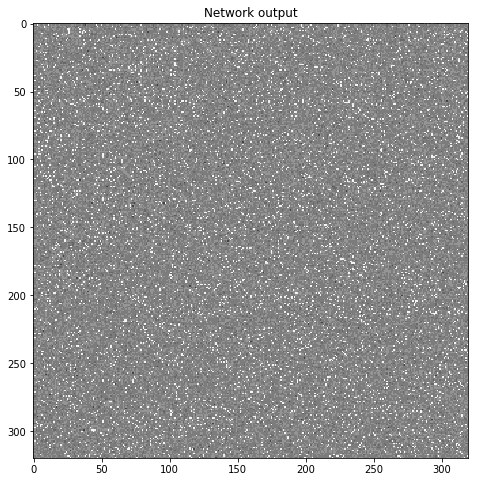

In [47]:
plt.figure(figsize=(8,8))
plt.title("Network output")
plt.imshow(T1_recon, cmap="gray",vmin=10)